In [1]:
import sys
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import pickle
import youtokentome as yttm
# import fasttext.util
# from fasttext import tokenize

maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [2]:
def unpack_poems_19k(file):
    all_data = []
    poems = []
    with open(file, encoding="utf8") as f:
        reader = csv.reader(f)
        for row in reader:
            all_data.append(row)
            
    all_data.pop(0)
    for row in all_data:
        if row[0] == "Александр Петрович Сумароков":
            continue
        poems.append(row[2])
    return poems

def unpack_stihi(file):
    all_data = []
    poems = []
    with open(file, encoding="utf8") as f:
        reader = csv.reader(f)
        for row in reader:
            all_data.append(row)
            
    all_data.pop(0)
    for row in all_data:
        poems.append(row[3])
    return poems

def unpack_news(file):
    news = []
    data = [json.loads(line) for line in open(file, 'r', encoding="utf8")]
#     with open(file) as f:
#         data = json.loads(f.read())
 
    for x in data:
        news.append(x['text'])
    return news

In [3]:
### for yttm, preprocess poems ###
def preprocess_poem(text_str):
    preproc_text_str = text_str.lower().replace('ё', 'е')
    spec_case_re = '(?:[\d]+[\s]+[а-я]+[\s]+[\d]+[\s])|(?:&lt;|&gt;|\[\d+\])'
    punctuation_re = '[^а-яА-Я]+'
    preproc_text_str = re.sub(spec_case_re, '', preproc_text_str) # remove some typical dirt
    preproc_text_str = re.sub(punctuation_re, ' ', preproc_text_str) # remove all but letters
    return preproc_text_str

def preprocessing_big_text_poem(all_texts):
    all_preproc_texts = []
    for i, text in enumerate(all_texts):
        if len(re.findall('[єЇїўčšžćśźńł]', text)) > 0: 
            continue
        
        text = text.strip() # delete space and \n from begin, end
        
        poem_lines = text.split('\n')
        if len(re.findall('[0-9]', poem_lines[-1])) > 0: # delete last line with data/url
            poem_lines.pop()
        text = ' ньюстр '.join(poem_lines)
#         text = text.replace('\n', ' ньюстр ')
        
        text = text.replace('...', '.')
        sentences_list = nltk.sent_tokenize(text) #.?! (not ...)
        sentences_str = ' ньюсент '.join(sentences_list)
        
        preproc_text_nopunct = preprocess_poem(sentences_str)
        preproc_text = preproc_text_nopunct.replace('ньюсент', '.')
        preproc_text = preproc_text.replace('ньюстр', '|')
        
        preproc_text = re.sub('[ ]{2,}', ' ', preproc_text)  
        preproc_text = re.sub('[. ]{4,}', ' . ', preproc_text)
        preproc_text = re.sub('[| ]{4,}', ' | ', preproc_text)
        preproc_text = re.sub('[ .|]{6,}', ' . | ', preproc_text) 
        preproc_text = preproc_text.strip(' |') # delete this from begin, end
        
        preproc_str_list = preproc_text.split('|')
        if len(preproc_str_list[0].split(' ')) > 15: # pass not poem (or with too lond str)
            continue
        
        preproc_word_list = preproc_text.split(' ')
        if len(preproc_word_list) < 10 or len(preproc_word_list) > 400: # pass too small|big poem 
            continue
            
        # make standart dot at end   
        if preproc_word_list[-1] != '.':
            preproc_word_list.append('.')
            preproc_text = ' '.join(preproc_word_list)
        
        all_preproc_texts.append(preproc_text)
    return all_preproc_texts

In [4]:
### for yttm, preprocess news ###
def preprocess_news(text_str):
    preproc_text_str = text_str.lower().replace('ё', 'е')
    spec_case_re = '(?:[\d]+[\s]+[а-я]+[\s]+[\d]+[\s])|(?:&lt;|&gt;|\[\d+\])'
    punctuation_re = '[^а-яА-Я]+'
    preproc_text_str = re.sub(spec_case_re, '', preproc_text_str) # remove some typical dirt
    preproc_text_str = re.sub(punctuation_re, ' ', preproc_text_str) # remove all but letters
    return preproc_text_str

def preprocessing_big_text_news(all_texts):
    all_preproc_texts = []
    for i, text in enumerate(all_texts):
        if len(re.findall('[єЇїўčšžćśźńł]', text)) > 0: 
            continue
        
        text = text.strip() # delete space and \n from begin, end
        
        # delete part with name, topic (like sport), author
        text_parts = text.split('</strong> ')
        if len(text_parts) == 1:
            text_parts = text.split('</strong>. ')
        if len(text_parts) == 1:
            continue
        text = text_parts[1]
        
        text = text.replace('...', '.')
        text = text.replace('.</p>', '. ')
        sentences_list = nltk.sent_tokenize(text) #.?! (not ...)
        sentences_str = ' ньюсент '.join(sentences_list)
        
        preproc_text_nopunct = preprocess_news(sentences_str)
        preproc_text = preproc_text_nopunct.replace('ньюсент', '.')
        
        preproc_text = re.sub('[ ]{2,}', ' ', preproc_text)  
        preproc_text = re.sub('[. ]{4,}', ' . ', preproc_text) 
        preproc_text = preproc_text.strip() 
                
        preproc_word_list = preproc_text.split(' ')
        if len(preproc_word_list) < 10 or len(preproc_word_list) > 400: # pass too small|big news 
            continue
            
        # make standart dot at end   
        if preproc_word_list[-1] != '.':
            preproc_word_list.append('.')
            preproc_text = ' '.join(preproc_word_list)
        
        all_preproc_texts.append(preproc_text)
    return all_preproc_texts

# main

### yttm news

In [18]:
data_news = unpack_news('datasets/ria_news.json')

In [19]:
len(data_news)

1003869

In [22]:
preproc_list_news = preprocessing_big_text_news(data_news[:200000])

In [23]:
len(preproc_list_news)

145041

In [24]:
preproc_list_news = preproc_list_news[:100000]
preproc_str_news = ' '.join(preproc_list_news)

In [72]:
for i in range(0, len(preproc_list_news), 1):
#     print(i)
#     print(data_news[i])
    print(i)
    print(preproc_list_news[i])

0
все покупатели одно двух трех и четырехкомнатных квартир в корпусах микрорайонов царицыно компании ндв недвижимость получат квадратный метр в подарок за каждые квадратных метров площади квартиры говорится в сообщении компании . к примеру покупая комнатную квартиру площадью квадратных метра покупатель получает квадратных метра в подарок отмечается в пресс релизе . таким образом вы платите только за квадратных метров а остальные получаете бесплатно семьям где воспитываются приемные дети ндв недвижимость подарит еще больше квадратных метров . за каждого приемного ребенка семья получит в подарок не один а квадратных метра добавляется в сообщении в нем также говорится о том что условия специального предложения действительны при оплате стоимости квартиры в течение дней со дня заключения договора или покупке квартиры в ипотеку . акция не суммируется с другими предложениями на квартиры . в подарок можно получить не более квадратных метров доля на рынке ндв недвижимость согласно оценкам самой

### yttm poem

In [11]:
data_poems = unpack_stihi('datasets/stihi-2008-2-1~2008-9-19.csv')
# data_poems = unpack_stihi('datasets/stihi_30k.csv')

In [12]:
len(data_poems)

519204

In [13]:
preproc_list_poems = preprocessing_big_text_poem(data_poems[:110000])

In [14]:
len(preproc_list_poems)

106246

In [16]:
preproc_list_poems = preproc_list_poems[:100000]
preproc_str_poems = ' '.join(preproc_list_poems)

In [11]:
for i in range(0, len(preproc_list_poems), 1):
    print(i)
    print(data_poems[i])
    print(preproc_list_poems[i])

10
0

Все классно, просто супер, мило
Однако грусть живёт в душе...
Всё почему-то опостыло,
Веселья нет давно уже...

Мечтать нет смысла, пусто в доме,
Застыл печально звук часов...
Сидишь и думаешь - доколе,
Ты будешь жить в плену сих снов...

Проснуться хочется и утром,
Вновь пробежаться по россе.
Руки, давно, родной, как-будто,
Коснуться - только не во сне...

Забыть тревоги и невзгоды,
Умчаться прочь на крыльях звёзд...
Встречать закаты и восходы,
Не понарошку, а всерьёз...

все классно просто супер мило | однако грусть живет в душе . | все почему то опостыло | веселья нет давно уже . | мечтать нет смысла пусто в доме | застыл печально звук часов . | сидишь и думаешь доколе | ты будешь жить в плену сих снов . | проснуться хочется и утром | вновь пробежаться по россе . | руки давно родной как будто | коснуться только не во сне . | забыть тревоги и невзгоды | умчаться прочь на крыльях звезд . | встречать закаты и восходы | не понарошку а всерьез .
1

Где апокалипсиса горн трубит во м

### save and token

In [17]:
with open('data/100k_poems_preproc.pickle', 'wb') as f:
    pickle.dump(preproc_list_poems, f)

In [25]:
with open('data/100k_news_preproc.pickle', 'wb') as f:
    pickle.dump(preproc_list_news, f)

In [20]:
# with open('data/100k_news_preproc.pickle', 'rb') as f:
#     preproc_list_news = pickle.load(f)
# with open('data/100k_poems_preproc.pickle', 'rb') as f:
#     preproc_list_poems = pickle.load(f)
# preproc_str = ""
# for poem, new in zip(preproc_list_poems, preproc_list_news):
#     preproc_str = preproc_str + poem + " " + new

KeyboardInterrupt: 

In [26]:
# preproc_str = preproc_str_poems + ' ' + preproc_str_news
with open('data/100k_all_embed_model_yttm.txt', 'w', encoding='utf-8') as f:
    f.write(preproc_str)

In [26]:
### см VOCAB_SIZE!!!!
yttm.BPE.train(
    data='data/100k_all_embed_model_yttm.txt', vocab_size=10000, model='100k_voc10k_all_embed_yttm.model', 
    coverage=0.9999, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3
)

In [24]:
token_model = yttm.BPE(model='100k_all_embed_yttm.model', n_threads=-1)
token_model.encode("граница украины и европы | конституция .", output_type=yttm.OutputType.SUBWORD, bos=True, eos=True)

['<BOS>',
 '▁граница',
 '▁украины',
 '▁и',
 '▁европы',
 '▁|',
 '▁конститу',
 'ция',
 '▁.',
 '<EOS>']

### check len

In [9]:
preproc_poems_len = np.array([len(poem) for poem in preproc_list_poems])

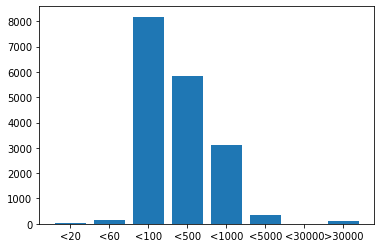

In [10]:
len_borders = np.array([20, 60, 100, 500, 1000, 5000, 30000])
len_groups = np.zeros(len(len_borders) + 1)
len_groups[0] = np.sum(preproc_poems_len < len_borders[0])
len_groups[-1] = np.sum(preproc_poems_len >= len_borders[-1])
for i in range(len(len_borders)-1):
    mask = (preproc_poems_len >= len_borders[i]) == (preproc_poems_len < len_borders[i+1])
    len_groups[i] = np.sum(mask)
group_names = [f'<{x}' for x in len_borders] + [f'>{len_borders[-1]}']
plt.bar(group_names, len_groups)
plt.show()

### old yttm

In [5]:
spec_case_re = re.compile('(?:[\d]+[\s]+[а-я]+[\s]+[\d]+[\s])|(?:&lt;|&gt;|\[\d+\])')  # datas and some trash
punctuation_re = re.compile('[^а-яА-Я]+')  #'[^a-zA-Zа-яА-Я0-9]+'
preproc_list_poems = preprocessing_big_text(data_poems, punctuation_re, spec_case_re)
preproc_list_poems = poem_filter(preproc_list_poems)
preproc_str_poems = ' '.join(preproc_list_poems)

TypeError: preprocessing_big_text_new() takes 1 positional argument but 3 were given

In [4]:
### for yttm ###
# normalization
def preprocess(text_str, punctuation_re, spec_case_re):
#     text_words = text_str.lower().replace('\n', ' ').split(' ')
#     text_words = text_str.lower().replace('\n', ' ньюстр ').replace('.\n', '. ньюстр')
    text_words = text_str.lower().replace('ё', 'е').split(' ')

    text_words = [spec_case_re.sub('', word) for word in text_words]  # remove some typical dirt
    text_words = [punctuation_re.sub('', word) for word in text_words]  # remove all but letters and numbers
    text_words = [word for word in text_words if word.strip() != '']  # remove ''

    return text_words

def preprocessing_big_text(all_texts, punctuation_re, spec_case_re):
    all_preproc_texts = []
    for text in all_texts:
        text = text.replace('\n', ' ньюстр ')
        sentences_list = nltk.sent_tokenize(text)
        sentences_str = ' ньюсент '.join(sentences_list)
        preproc_words_list_nopunct = preprocess(sentences_str, punctuation_re, spec_case_re)
        preproc_words_list =[]
        for word in preproc_words_list_nopunct:
            if word == 'ньюсент':
                preproc_words_list.append('.')
                continue
            if word == 'ньюстр':
                preproc_words_list.append('\n')
                continue
            preproc_words_list.append(word)
        preproc_words_list.append('.')
        preproc_words_str = ' '.join(preproc_words_list)
        
        preproc_words_str = re.sub('[.| ]{4,}', ' . ', preproc_words_str)
        preproc_words_str = re.sub('[\n| ]{4,}', ' \n ', preproc_words_str)
        if len(preproc_words_list) > 5:
            all_preproc_texts.append(' '.join(preproc_words_list))
    return all_preproc_texts

def poem_filter(all_texts):
    all_filter_texts = []
    for text_str in all_texts:
        text_list = text_str.split(' ')
        if len(text_list) > 5: 
            all_filter_texts.append(text_str)
    return all_filter_texts

### fasttext

In [ ]:
### for fasttext ###
# normalization, lemmatization
def preprocess(text_str, punctuation_re):
    text_words = text_str.lower().replace('\n', ' ').split(' ')

    text_words = [punctuation_re.sub('', word) for word in text_words]  # remove all but letters and numbers
    text_words = [word for word in text_words if word.strip() != '']  # remove ''

    return text_words

# preproc all data with sentence tokenization
def preprocessing_big_text(all_texts, punctuation_re):
    all_preproc_texts = []
    for text in all_texts:
        sentences_list = nltk.sent_tokenize(text)
        sentences_str = ' newsent '.join(sentences_list)
        preproc_words_list = preprocess(sentences_str, punctuation_re)
        preproc_words_list = [word if word!='newsent' else '.' for word in preproc_words_list] 
        preproc_words_list.insert(0, '</s>') # for fasttext EOS token - start + end
        preproc_words_list.append('</s>')
#         preproc_words_list = [word if word!='newsent' else '</s>' for word in preproc_words_list] # for fasttext EOS token
        all_preproc_texts.append(preproc_words_list)
    
    return all_preproc_texts

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')  

In [ ]:
punctuation_re = re.compile('[^a-zA-Zа-яА-Я0-9]+')
# к токенам в начале и в конце токен '</s>', а между предл - точка обыч
preproc_token_poems = preprocessing_big_text(data_poems[1:113], punctuation_re)

In [ ]:
print([i for i in preproc_token_poems])

[['</s>', 'на', 'серебряные', 'шпоры', 'я', 'в', 'раздумии', 'гляжу', 'за', 'тебя', 'скакун', 'мой', 'скорый', 'за', 'бока', 'твои', 'дрожу', '.', 'наши', 'предки', 'их', 'не', 'знали', 'и', 'гарцуя', 'средь', 'степей', 'толстой', 'плеткой', 'погоняли', 'недоезжаных', 'коней', '.', 'но', 'с', 'успехом', 'просвещенья', 'вместо', 'грубой', 'старины', 'введены', 'изобретенья', 'чужеземной', 'стороны', 'в', 'наше', 'время', 'кормят', 'холят', 'берегут', 'спинную', 'честь', 'прежде', 'били', 'нынче', 'колют', '.', 'что', 'же', 'выгодней', '.', 'бог', 'весть', '</s>'], ['</s>', 'пилигрим', 'аллах', 'ли', 'там', 'среди', 'пустыни', 'застывших', 'волн', 'воздвиг', 'твердыни', 'притоны', 'ангелам', 'своим', 'иль', 'дивы', 'словом', 'роковым3', 'стеной', 'умели', 'так', 'высоко', 'громады', 'скал', 'нагромоздить', 'чтоб', 'путь', 'на', 'север', 'заградить', 'звездам', 'кочующим', 'с', 'востока', '.', 'вот', 'свет', 'вс', 'небо', 'озарил', 'то', 'не', 'пожар', 'ли', 'цареграда', '.', 'иль', 'бог'

In [ ]:
word_embed_vec = [[ft.get_word_vector(x) for x in poem] for poem in preproc_token_poems]
# print(word_embed_vec[0][16])

In [ ]:
# сохранение эмбеддингов
file = open('poems_embed_ft.pickle', 'wb')
pickle.dump(word_embed_vec, file)

In [ ]:
ft.get_nearest_neighbors('думать')
ft.get_dimension() # default dimention = 300

[(0.8122648596763611, 'размышлять'),
 (0.7895683646202087, 'подумать'),
 (0.7874324917793274, 'задумываться'),
 (0.7479910254478455, 'говорить'),
 (0.7412926554679871, 'рассуждать'),
 (0.7208094596862793, 'Думать'),
 (0.7094479203224182, 'думать-'),
 (0.7082861661911011, 'думать.'),
 (0.7077756524085999, 'думаться'),
 (0.7072365283966064, 'задумывать')]

In [ ]:
tokens = tokenize(data_poems[1])
print(tokens)

['На', 'серебряные', 'шпоры', '</s>', 'Я', 'в', 'раздумии', 'гляжу;', '</s>', 'За', 'тебя,', 'скакун', 'мой', 'скорый,', '</s>', 'За', 'бока', 'твои', 'дрожу.', '</s>', 'Наши', 'предки', 'их', 'не', 'знали', '</s>', 'И,', 'гарцуя', 'средь', 'степей,', '</s>', 'Толстой', 'плеткой', 'погоняли', '</s>', 'Недоезжаных', 'коней.', '</s>', 'Но', 'с', 'успехом', 'просвещенья', '</s>', 'Вместо', 'грубой', 'старины', '</s>', 'Введены', 'изобретенья', '</s>', 'Чужеземной', 'стороны;', '</s>', 'В', 'наше', 'время', 'кормят,', 'холят,', '</s>', 'Берегут', 'спинную', 'честь…', '</s>', 'Прежде', 'били', '–', 'нынче', 'колют!..', '</s>', 'Что', 'же', 'выгодней?', '–', 'бог', 'весть!..']
